In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/pancancer.TIGIT.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE,joined.TIGIT_label
0,71.806464,129.127076,1.158576,122.432688,194.239152,0.369681,0.664784,0.630319,6722.417551,6665.889385,...,162597,4593,24879,38851,43444,12789,27081,26708,39497,1
1,82.396624,168.316672,2.677280,145.747888,228.144512,0.361160,0.737763,0.638840,6594.895183,6647.129359,...,65822,3040,14794,24867,27907,1328,3955,6120,7448,1
2,26.877520,53.040932,3.571664,44.355952,71.233472,0.377316,0.744607,0.622684,5833.355998,6531.812070,...,45076,1546,7789,12735,14281,729,2571,4174,4903,1
3,43.128576,111.292004,0.742096,98.095856,141.224432,0.305390,0.788051,0.694610,7160.616676,7223.818109,...,44382,1897,5594,9934,11831,1837,2488,1965,3802,1
4,0.685216,2.596956,1.605504,8.142384,8.827600,0.077622,0.294186,0.922378,4479.384456,4093.277627,...,17273,452,1604,4450,4902,181,289,527,708,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,199.295932,105.349612,3.874452,56.462540,255.758472,0.779235,0.411911,0.220765,6308.553319,5470.245899,...,204940,44,81,81,125,23816,15970,9274,33090,1
1879,56.896288,44.219920,3.791788,22.847336,79.743624,0.713490,0.554526,0.286510,6262.027952,6762.026733,...,108622,404,854,1272,1676,8113,24825,26572,34685,1
1880,146.597648,37.981336,10.317812,18.585056,165.182704,0.887488,0.229935,0.112512,7054.863156,5189.711650,...,20279,35,83,750,785,1295,2838,4368,5663,0
1881,366.084516,29.663968,8.606332,9.045324,375.129840,0.975887,0.079077,0.024113,7329.341194,4570.850192,...,105929,2780,149,528,3308,10542,2238,2340,12882,1


In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,0.361330,1.277181,-0.471264,1.738874,1.168419,-0.680931,0.322342,0.680931,0.339682,0.423225,...,0.699581,0.599113,0.015849,0.807662,0.661064,0.576628,1.073903,0.441838,0.061657,0.243879
1,0.571818,2.037783,-0.395798,2.297845,1.605151,-0.725252,0.724480,0.725252,0.188609,0.399138,...,-0.146560,-0.226935,-0.170634,0.190760,0.176248,0.110002,-0.372191,-0.441404,-0.427132,-0.459751
2,-0.531671,-0.199519,-0.351355,-0.132980,-0.416006,-0.641218,0.762189,0.641218,-0.713568,0.251081,...,-0.330429,-0.404018,-0.350034,-0.237738,-0.244360,-0.299230,-0.447769,-0.494262,-0.473333,-0.515625
3,-0.208668,0.931033,-0.491960,1.155410,0.485541,-1.015329,1.001577,1.015329,0.858806,1.139557,...,-0.392965,-0.409942,-0.307886,-0.372007,-0.341468,-0.372811,-0.307967,-0.497432,-0.525778,-0.539798
4,-1.052265,-1.178549,-0.449056,-1.001184,-1.219851,-2.200033,-1.719762,2.200033,-2.317585,-2.879786,...,-0.593083,-0.641338,-0.481401,-0.616076,-0.531595,-0.580911,-0.516913,-0.581418,-0.559918,-0.607726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,2.895290,0.815702,-0.336309,0.157270,1.960844,1.449307,-1.071065,-1.449307,-0.150613,-1.111878,...,-0.179434,0.960543,-0.530393,-0.709239,-0.683065,-0.724379,2.465237,0.017480,-0.352252,0.103214
1879,0.064977,-0.370720,-0.340417,-0.648640,-0.306388,1.107345,-0.285211,-1.107345,-0.205730,0.546657,...,-0.120241,0.138395,-0.487165,-0.661954,-0.641774,-0.677798,0.483908,0.355676,0.058428,0.138232
1880,1.847867,-0.491800,-0.016131,-0.750826,0.794145,2.012370,-2.073801,-2.012370,0.733522,-1.472060,...,-0.601714,-0.615679,-0.531474,-0.709116,-0.659871,-0.704558,-0.376354,-0.484065,-0.468727,-0.498940
1881,6.210354,-0.653225,-0.101176,-0.979537,3.498455,2.472168,-2.905077,-2.472168,1.058689,-2.266624,...,-0.615340,0.115409,-0.201855,-0.705079,-0.667568,-0.628784,0.790387,-0.506980,-0.516875,-0.340448


In [5]:
y = df.iloc[:,607]
print(np.sum(y))

943


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/pancancer.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 20


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,1
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,9
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,9


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

627 627
628 628
628 628
0.5007974481658692
0.5
0.5015923566878981


### Outer Loop 1

In [8]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(1255, 607) (1255,)
(628, 607) (628,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.755879365079365, 0.7603365079365081, 0.7635746031746031, 0.7704444444444445, 0.758647619047619, 0.7589650793650794, 0.7614031746031747, 0.7599111111111112, 0.7635936507936508, 0.7363555555555555, 0.7448380952380952, 0.7400761904761904, 0.7564126984126984, 0.7636952380952381, 0.7262603174603175, 0.7722793650793651, 0.6997968253968254, 0.6959619047619048, 0.7123936507936508, 0.7564698412698412, 0.7708190476190475, 0.7648380952380952, 0.7596571428571429, 0.7561396825396824, 0.7525587301587302, 0.7548825396825396, 0.5940825396825397, 0.5, 0.5, 0.5]


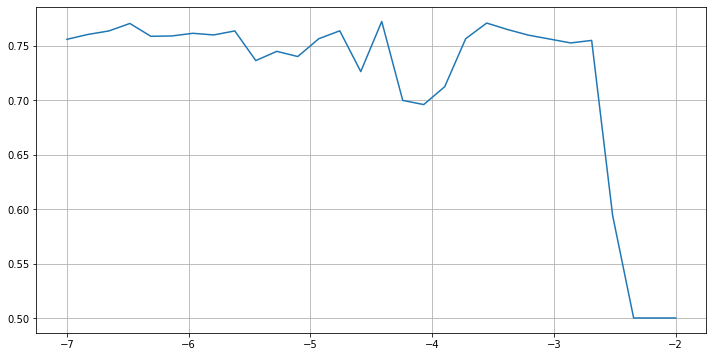

0.012109159812750188 -4.413793103448276


In [11]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

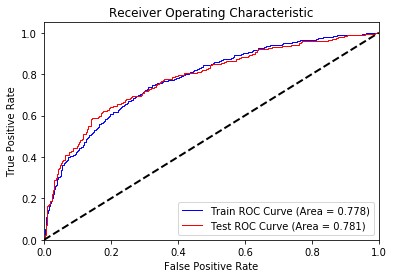

In [10]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

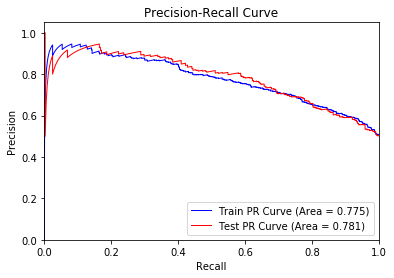

In [11]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 27


,HIF,Beta,Cluster
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.764083,10
117,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN ESI_0080_HE,0.539954,10
284,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.467372,10
177,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN ESI_00...,0.446599,10
405,DENSITY [LYMPHOCYTE CELLS] IN [ESI_0080]_HE,0.420049,10
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.397728,10
285,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [ESI_008...,0.397018,10
287,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [TUMOR]_HE,0.312745,10
157,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.302642,10
97,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.290732,10


### Outer Loop 2

In [13]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(1255, 607) (1255,)
(628, 607) (628,)


In [13]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.7395301587301587, 0.7350857142857143, 0.7208507936507937, 0.7385142857142858, 0.7330158730158731, 0.7303873015873016, 0.7440380952380952, 0.7395936507936507, 0.7214222222222222, 0.7346730158730159, 0.7371936507936507, 0.7301333333333334, 0.7492825396825398, 0.7490031746031748, 0.7386539682539682, 0.6905650793650795, 0.7492698412698413, 0.7073333333333334, 0.7072126984126985, 0.7231873015873017, 0.7208507936507935, 0.7018285714285715, 0.7713904761904762, 0.7693460317460317, 0.7683428571428571, 0.7677968253968255, 0.7652698412698412, 0.7640888888888888, 0.7617142857142858, 0.759784126984127]


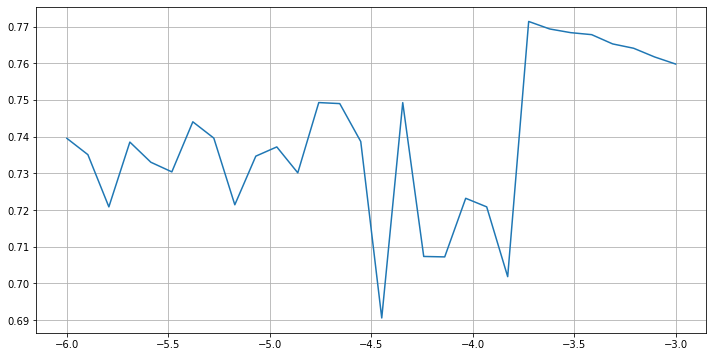

0.02413389654491333 -3.724137931034482


In [15]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

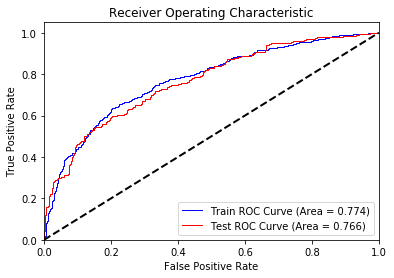

In [15]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

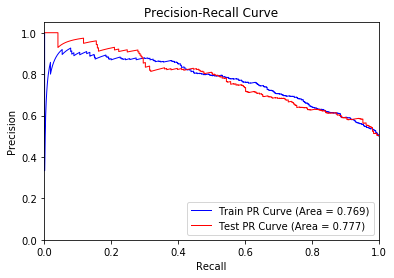

In [17]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 35


,HIF,Beta,Cluster
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.705031,10
117,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN ESI_0080_HE,0.620936,10
284,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.616478,10
285,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [ESI_008...,0.568284,10
177,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN ESI_00...,0.537036,10
405,DENSITY [LYMPHOCYTE CELLS] IN [ESI_0080]_HE,0.374527,10
157,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.352771,10
406,DENSITY [LYMPHOCYTE CELLS] IN [STROMA]_HE,0.349462,10
97,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.343100,10
287,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [TUMOR]_HE,0.340216,10


### Outer Loop 3

In [19]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(1256, 607) (1256,)
(627, 607) (627,)


In [17]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.7662742252456539, 0.7780431342907533, 0.7755234063995968, 0.7669006802721088, 0.7702121441169061, 0.765718216175359, 0.7595545477450238, 0.7677091458805745, 0.7493117661879567, 0.7630224237843286, 0.7679858906525573, 0.7185339380196523, 0.7409404887881078, 0.7242352229780802, 0.7769309145880574, 0.7530008566389519, 0.7378878306878308, 0.7058180901990426, 0.7139431594860166, 0.6701547996976569, 0.7504682287729907, 0.7683233056185438, 0.7567322751322751, 0.7748403124212647, 0.7735883093978333, 0.7726978080120939, 0.7703148400100781, 0.7673532879818594, 0.7597296044343663, 0.7589690098261527]


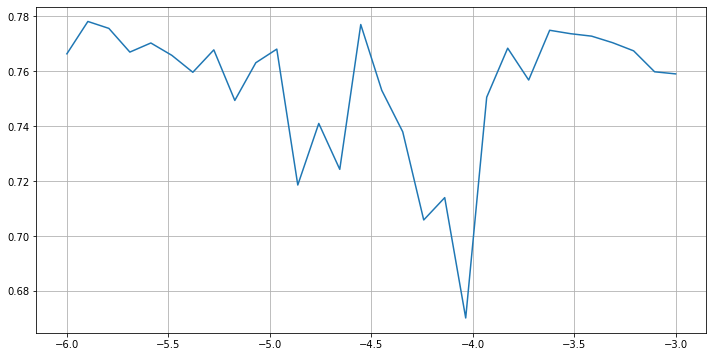

0.0027489074857791197 -5.896551724137931


In [19]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

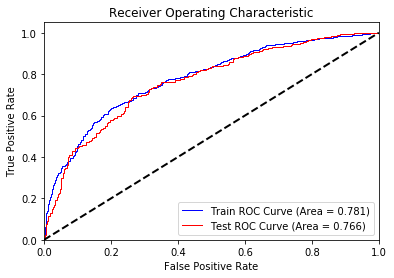

In [21]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

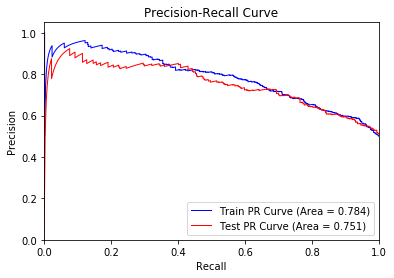

In [22]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 28


,HIF,Beta,Cluster
117,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN ESI_0080_HE,0.769993,10
177,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN ESI_00...,0.637774,10
284,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.540617,10
405,DENSITY [LYMPHOCYTE CELLS] IN [ESI_0080]_HE,0.527573,10
285,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [ESI_008...,0.526000,10
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.516079,10
97,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.370342,10
58,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN STROMA_HE,0.339776,10
157,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.323798,10
57,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF LYMPHOCYTE IN ESI_0080_HE,0.318511,10


## Compute Ensemble Model

In [24]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
286,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [STROMA]_HE,0.764083,0.705031,0.516079,10,0.661731
117,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF LYMPHOCYTE IN ESI_0080_HE,0.539954,0.620936,0.769993,10,0.643628
284,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.467372,0.616478,0.540617,10,0.541489
177,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF LYMPHOCYTE IN ESI_00...,0.446599,0.537036,0.637774,10,0.540470
285,COUNT PROP [[[CANCER CELLS] SELECTED BY [LYMPHOCYTE_RADIUS_80]] OVER [CANCER CELLS]] IN [ESI_008...,0.397018,0.568284,0.526000,10,0.497101
...,...,...,...,...,...,...
601,TOTAL [MACROPHAGE CELLS] IN [STROMA]_HE,0.000000,-0.033073,0.000000,1,-0.011024
141,CELL CLUSTERING PROPERTIES: NUMBER OF CLUSTERS OF MACROPHAGE IN ESI_0080_HE,-0.031924,-0.001663,0.000000,1,-0.011196
42,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF MACROPHAGE IN STROMA_HE,-0.029270,-0.020544,0.000000,1,-0.016605
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,-0.052548,-0.049516,0.000000,1,-0.034021


## Compute Final Train / Test Metrics

In [25]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.7782763945184328, 0.7742727692925024, 0.7805306009640374]
0.777693254924991 0.0025878115781996338


In [26]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.780556823368325, 0.7661669844618443, 0.7656539345963655]
0.770792580808845 0.0069075383753977124


In [27]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.7745957487823686, 0.7685570616853803, 0.7838894539932404]
0.7756807548203298 0.0063062663041000225


In [28]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.7814354375898345, 0.7770430405910604, 0.7512135124576818]
0.7698973302128588 0.013332593453143667


## Evaluate Hold-Out Set

In [29]:
holdout_df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/pancancer.tigit.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE,joined.TIGIT_label
0,34.327408,81.342520,0.551184,62.415296,96.742704,0.354832,0.840813,0.645168,6633.257717,7130.446085,...,25000,1813,4109,7559,9372,1564,2336,2231,3795,0
1,18.961888,32.686732,6.767424,46.949360,65.911248,0.287688,0.495920,0.712312,5611.085772,6026.546207,...,160321,4956,12171,33449,38405,1385,5787,12023,13408,1
2,2.042160,2.735584,1.230176,7.568592,9.610752,0.212487,0.284638,0.787513,3935.741179,5306.740189,...,28523,413,1643,6123,6536,849,2863,8027,8876,1
3,67.331360,79.770572,0.214880,26.367440,93.698800,0.718594,0.851351,0.281406,7514.344122,7332.800369,...,26272,3188,4986,4670,7858,1266,1532,634,1900,0
4,24.716784,34.905768,7.369856,42.780144,67.496928,0.366191,0.517146,0.633809,5589.983127,6240.323681,...,126871,3673,12495,38551,42224,2081,8924,20944,23025,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,33.106596,24.048208,0.038168,8.643060,41.749656,0.792979,0.576010,0.207021,7547.275858,6714.751648,...,16180,2,13,11,13,913,2097,1714,2627,0
565,13.164656,21.161784,90.599176,117.923880,131.088536,0.100426,0.161431,0.899574,4797.422966,5308.291727,...,26317,98,359,1975,2073,275,461,5835,6110,1
566,33.419444,17.256700,2.542452,8.763660,42.183104,0.792247,0.409090,0.207753,6843.317393,6259.368527,...,38267,87,100,282,369,2192,3102,4004,6196,1
567,100.681360,57.929560,6.622132,20.367232,121.048592,0.831743,0.478565,0.168257,7434.365367,6478.238887,...,61808,51,133,260,311,5094,8071,9580,14674,1


In [30]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,AREA.PROP...EPITHELIAL..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...ESI_0080..OVER..TUMOR...IN..TISSUE._HE,AREA.PROP...STROMA..OVER..TUMOR...IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,...,TOTAL..LYMPHOCYTE.CELLS..IN..STROMA._HE,TOTAL..LYMPHOCYTE.CELLS..IN..TUMOR._HE,TOTAL..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,TOTAL..MACROPHAGE.CELLS..IN..ESI_0080._HE,TOTAL..MACROPHAGE.CELLS..IN..STROMA._HE,TOTAL..MACROPHAGE.CELLS..IN..TUMOR._HE,TOTAL..PLASMA.CELLS..IN..EPITHELIAL._HE,TOTAL..PLASMA.CELLS..IN..ESI_0080._HE,TOTAL..PLASMA.CELLS..IN..STROMA._HE,TOTAL..PLASMA.CELLS..IN..TUMOR._HE
0,-0.401228,0.491194,-0.563588,0.427973,-0.033252,-0.856158,1.389242,0.856158,0.320978,1.253617,...,-0.555280,-0.595571,-0.349375,-0.428895,-0.303401,-0.328244,-0.359554,-0.527360,-0.513014,-0.538092
1,-0.745755,-0.611151,-0.140585,0.004822,-0.488463,-1.229454,-0.704946,1.229454,-1.038031,-0.567944,...,1.083807,0.783841,0.213717,0.182076,0.543299,0.520568,-0.381211,-0.374240,-0.257329,-0.309402
2,-1.125131,-1.289724,-0.517384,-1.072644,-1.319711,-1.647546,-1.987853,1.647546,-3.265454,-1.755707,...,-0.486548,-0.559659,-0.600195,-0.615778,-0.350363,-0.411158,-0.446061,-0.503977,-0.361671,-0.417217
3,0.338790,0.455580,-0.586473,-0.558304,-0.078193,1.166227,1.453229,-1.166227,1.492410,1.587525,...,-0.680106,-0.582605,-0.103033,-0.362432,-0.397882,-0.372508,-0.395608,-0.563033,-0.554714,-0.583173
4,-0.616718,-0.560876,-0.099591,-0.109249,-0.465051,-0.793005,-0.576064,0.793005,-1.066087,-0.215187,...,0.643193,0.442864,-0.016142,0.206630,0.710153,0.632221,-0.297002,-0.235053,-0.024387,-0.080617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,-0.428601,-0.806865,-0.598498,-1.043246,-0.845196,1.579783,-0.218643,-1.579783,1.536194,0.567674,...,-0.684690,-0.685479,-0.673829,-0.739306,-0.550248,-0.601865,-0.438318,-0.537964,-0.526513,-0.565878
565,-0.875741,-0.872260,5.564001,1.946699,0.473847,-2.270568,-2.735964,2.270568,-2.119821,-1.753147,...,-0.519166,-0.582146,-0.656630,-0.713084,-0.486018,-0.541639,-0.515509,-0.610553,-0.418907,-0.483019
566,-0.421586,-0.960733,-0.428086,-1.039947,-0.838797,1.575715,-1.232178,-1.575715,0.600259,-0.183761,...,-0.495419,-0.460332,-0.658600,-0.732713,-0.541386,-0.591457,-0.283572,-0.493373,-0.466718,-0.480973
567,1.086568,-0.039250,-0.150472,-0.722471,0.325613,1.795300,-0.810331,-1.795300,1.386076,0.177400,...,-0.426156,-0.220364,-0.665050,-0.730212,-0.542105,-0.593153,0.067539,-0.272900,-0.321119,-0.279284


In [31]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

297


In [32]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [33]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

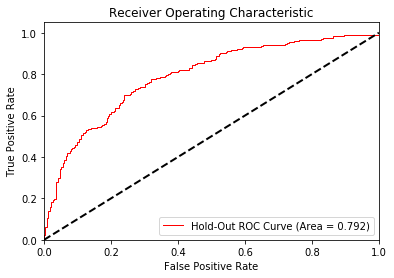

In [34]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.792


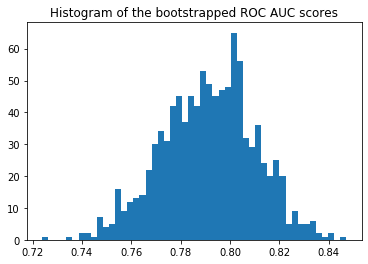

Confidence interval for the score: [0.754 - 0.827]


In [35]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

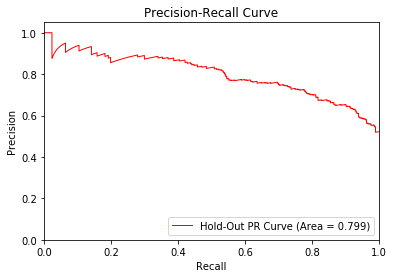

In [36]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.799


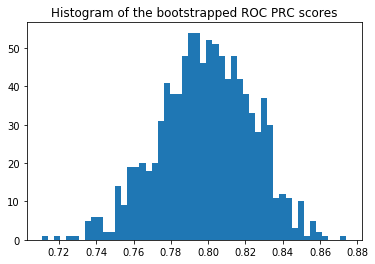

Confidence interval for the score: [0.750 - 0.844]


In [37]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))